This tutorial and the assets can be downloaded as part of the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/tree/main/wallaroo-model-cookbooks/computer-vision).

## Step 03: Detecting Objects Using Shadow Deploy

The following tutorial demonstrates how to use two trained models, one based on the resnet50, the other on mobilenet, deployed in Wallaroo to detect objects.  This builds on the previous tutorials in this series, Step 01: Detecting Objects Using mobilenet" and  "Step 02: Detecting Objects Using resnet50".

For this tutorial, the Wallaroo feature [Shadow Deploy](https://docs.wallaroo.ai/wallaroo-tutorials/wallaroo-tutorials-testing/wallaroo-shadow-deployment-tutorial/) will be used to submit inference requests to both models at once.  The mobilnet object detector is the control and the faster-rcnn object detector is the challenger.  The results between the two will be compared for their confidence, and that confidence will be used to draw bounding boxes around identified objects.

This process will use the following steps:

1. Create a Wallaroo workspace and pipeline.
1. Upload a trained resnet50 ML model and trained mobilenet model and add them as a shadow deployed step with the mobilenet as the control model.
1. Deploy the pipeline.
1. Perform an inference on a sample image.
1. Based on the 
1. Draw the detected objects, their bounding boxes, their classifications, and the confidence of the classifications on the provided image.
1. Review our results.

## Steps

### Import Libraries

The first step will be to import our libraries.  Please check with **Step 00: Introduction and Setup** and verify that the necessary libraries and applications are added to your environment.

In [1]:
# preload needed libraries 

import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework
from IPython.display import display
from IPython.display import Image
import pandas as pd
import json
import datetime
import time
import cv2
import matplotlib.pyplot as plt
import string
import random
import pyarrow as pa
import sys
import asyncio
pd.set_option('display.max_colwidth', None)

import sys

import utils



### Connect to the Wallaroo Instance

The first step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

In [2]:
# Login through local service

wl = wallaroo.Client()

wl = wallaroo.Client()

wallarooPrefix = "doc-test."
wallarooSuffix = "wallaroocommunity.ninja"

wl = wallaroo.Client(api_endpoint=f"https://{wallarooPrefix}api.{wallarooSuffix}", 
                    auth_endpoint=f"https://{wallarooPrefix}keycloak.{wallarooSuffix}", 
                    auth_type="sso")

### Set Variables

The following variables and methods are used later to create or connect to an existing workspace, pipeline, and model.  This example has both the resnet model, and a post process script.

In [3]:
workspace_name = f'shadowimageworkspacetest'
pipeline_name = f'shadowimagepipelinetest'
control_model_name = f'mobilenet'
control_model_file_name = 'models/mobilenet.pt.onnx'
challenger_model_name = f'resnet50'
challenger_model_file_name = 'models/frcnn-resnet.pt.onnx'

In [4]:
def get_workspace(name, client):
    workspace = None
    for ws in client.list_workspaces():
        if ws.name() == name:
            workspace= ws
    if(workspace == None):
        workspace = client.create_workspace(name)
    return workspace


### Create Workspace

The workspace will be created or connected to, and set as the default workspace for this session.  Once that is done, then all models and pipelines will be set in that workspace.

In [5]:
workspace = get_workspace(workspace_name, wl)
wl.set_current_workspace(workspace)
wl.get_current_workspace()

{'name': 'shadowimageworkspacetest', 'id': 12, 'archived': False, 'created_by': '857ba380-b066-4f36-bd72-60e7e6213723', 'created_at': '2023-12-07T19:22:46.854353+00:00', 'models': [], 'pipelines': []}

### Create Pipeline and Upload Model

We will now create or connect to an existing pipeline as named in the variables above, then upload each of the models.

In [6]:
pipeline = wl.build_pipeline(pipeline_name)

In [7]:
control =  wl.upload_model(control_model_name, control_model_file_name, 
                           framework=Framework.ONNX).configure(batch_config="single", 
                                                               tensor_fields=["tensor"])

In [8]:
challenger = wl.upload_model(challenger_model_name, challenger_model_file_name, 
                             framework=Framework.ONNX).configure(batch_config="single", 
                                                                 tensor_fields=["tensor"])

In [9]:
input_schema = pa.schema([
    pa.field('boxes', pa.list_(pa.list_(pa.float32(), list_size=4))),
    pa.field('classes', pa.list_(pa.int64())),
    pa.field('confidences', pa.list_(pa.float32())),])

output_schema = pa.schema([
    pa.field('boxes', pa.list_(pa.list_(pa.float32(), list_size=4))),
    pa.field('classes', pa.list_(pa.int64())),
    pa.field('confidences', pa.list_(pa.float32())),
    pa.field('avg_conf', pa.float32()),
])

module_post_process_model = wl.upload_model("cv-post-process-drift-detection", "./models/post-process-drift-detection-arrow.py",framework=Framework.PYTHON) \
    .configure('python', input_schema=input_schema, output_schema=output_schema)

### Shadow Deploy Pipeline

For this step, rather than deploying each model into a separate step, both will be deployed into a single step as a Shadow Deploy step.  This will take the inference input data and process it through both pipelines at the same time.  The inference results for the control will be stored in it's `['outputs']` array, while the results for the challenger are stored the `['shadow_data']` array.

In [10]:
pipeline.add_shadow_deploy(control, [challenger])
pipeline.add_model_step(module_post_process_model)


name,shadowimagepipelinetest
created,2023-12-07 19:22:50.381884+00:00
last_updated,2023-12-07 19:22:50.381884+00:00
deployed,(none)
arch,None
tags,
versions,fc83b01d-f9c3-4b9a-885f-a10bd3591b14
steps,
published,False


In [11]:
pipeline.deploy()

name,shadowimagepipelinetest
created,2023-12-07 19:22:50.381884+00:00
last_updated,2023-12-07 19:28:00.380446+00:00
deployed,True
arch,None
tags,
versions,"50f1a74b-25a0-4340-98b6-7f8937de4ff1, fc83b01d-f9c3-4b9a-885f-a10bd3591b14"
steps,mobilenet
published,False


In [12]:
pipeline.status()

{'status': 'Running',
 'details': [],
 'engines': [{'ip': '10.244.3.177',
   'name': 'engine-bcb9576dd-kgm27',
   'status': 'Running',
   'reason': None,
   'details': [],
   'pipeline_statuses': {'pipelines': [{'id': 'shadowimagepipelinetest',
      'status': 'Running'}]},
   'model_statuses': {'models': [{'name': 'resnet50',
      'version': 'bf7ca066-0f1e-4348-8f78-a8145c491b43',
      'sha': '43326e50af639105c81372346fb9ddf453fea0fe46648b2053c375360d9c1647',
      'status': 'Running'},
     {'name': 'mobilenet',
      'version': '45a03c16-9c6a-4116-9ccf-9edbe4580800',
      'sha': '9044c970ee061cc47e0c77e20b05e884be37f2a20aa9c0c3ce1993dbd486a830',
      'status': 'Running'},
     {'name': 'cv-post-process-drift-detection',
      'version': '8ad978eb-0ebd-4de1-ae3e-9a222de43a99',
      'sha': 'e42d3acecb6f2edbfa97c0f6e2075ff3e0a2b7df150a7e8b51b6ed7f1b098282',
      'status': 'Running'}]}}],
 'engine_lbs': [{'ip': '10.244.4.183',
   'name': 'engine-lb-584f54c899-xgg7j',
   'status': 

### Prepare input image

Next we will load a sample image and resize it to the width and height required for the object detector.

We will convert the image to a numpy ndim array and add it do a dictionary

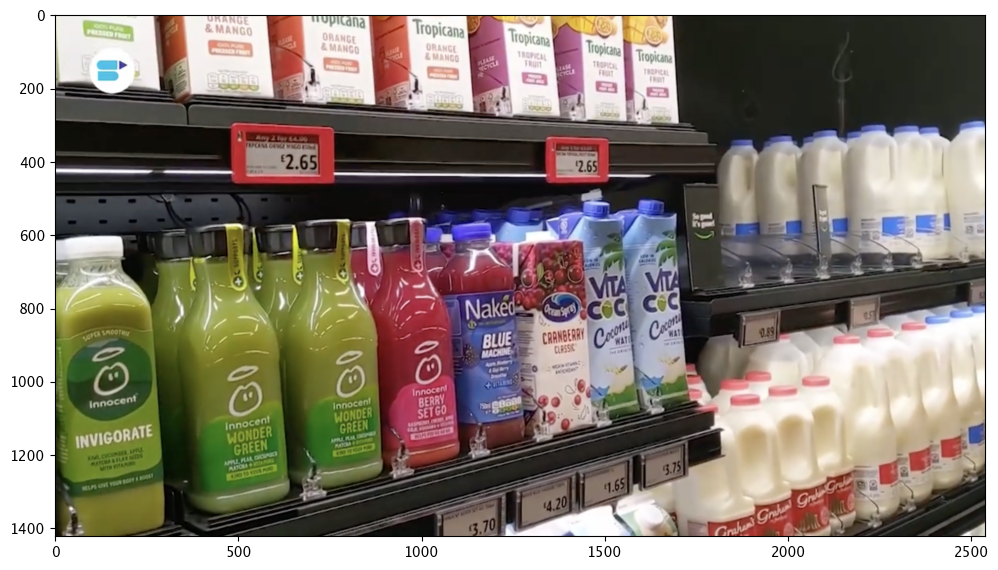

In [16]:
image = cv2.imread('./data/images/input/example/dairy_bottles.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,8))
plt.grid(False)
plt.imshow(image)
plt.show()

In [13]:
width, height = 640, 480
dfImage, resizedImage = utils.loadImageAndConvertToDataframe('./data/images/input/example/dairy_bottles.png', width, height)

### Run Inference using Shadow Deployment

Now lets have the model detect the objects on the image by running inference and extracting the results 

In [14]:
startTime = time.time()
infResults = pipeline.infer(dfImage, timeout=300)
endTime = time.time()
infResults.loc[:, ['time', 'out.avg_conf']]

,time,out.avg_conf
0,2023-12-07 19:29:08.210,0.289505


### Extract Control Inference Results

First we'll extract the inference result data for the control model and map it onto the image.

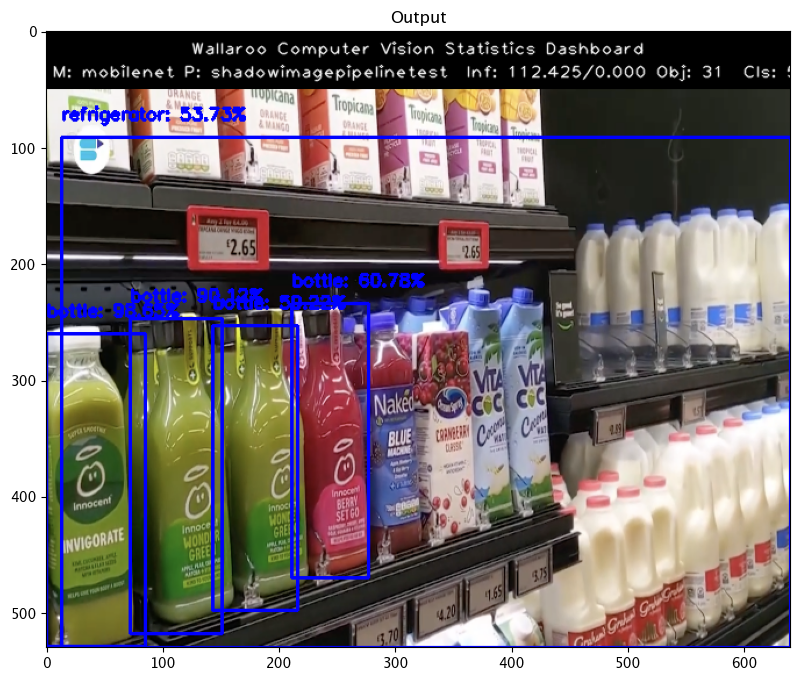

In [15]:
elapsed = 1.0
results = {
    'model_name' : control_model_name,
    'pipeline_name' : pipeline_name,
    'width': width,
    'height': height,
    'image' : resizedImage,
    'inf-results' : infResults,
    'confidence-target' : 0.50,
    'inference-time': (endTime-startTime),
    'onnx-time' : int(elapsed) / 1e+9,
    'classes_file': "./models/coco_classes.pickle",                 
    'color': 'BLUE'
}

image = utils.drawDetectedObjectsFromInference(results)

### Display the Challenger Results

Here we will use the Wallaroo CVDemo helper class to draw the challenger model results on the input image.

In [29]:
# get the average confidence values from the shadow deployed model

resnet50_avg_conf = sum(infResults["out_resnet50.confidences"][0]) / len(infResults["out_resnet50.confidences"][0])
resnet50_avg_conf

0.3588037966200001

In [33]:
# compare the models


display(f'Mobilenet Average Confidence: {infResults["out.avg_conf"][0]}')
display(f'Resnet Average Confidence: {sum(infResults["out_resnet50.confidences"][0]) / len(infResults["out_resnet50.confidences"][0])}')

'Mobilenet Average Confidence: 0.28950533'

'Resnet Average Confidence: 0.3588037966200001'

In [30]:
pipeline.undeploy()

name,shadowimagepipelinetest
created,2023-12-07 19:22:50.381884+00:00
last_updated,2023-12-07 19:28:00.380446+00:00
deployed,False
arch,None
tags,
versions,"50f1a74b-25a0-4340-98b6-7f8937de4ff1, fc83b01d-f9c3-4b9a-885f-a10bd3591b14"
steps,mobilenet
published,False


### Conclusion

Notice the difference in the control confidence and the challenger confidence.  <b>Clearly we can see in this example the challenger resnet50 model is performing better than the control mobilenet model</b>.  This is likely due to the fact that frcnn resnet50 model is a 2 stage object detector vs the frcnn mobilenet is a single stage detector.

This completes using Wallaroo's shadow deployment feature to compare different computer vision models.
